## import

In [74]:
import random

random_seed = 10
random.seed(random_seed)

In [6]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 13.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatib

In [75]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


from google.colab import drive
drive.mount('/content/gdrive')


#Shared drive version at everyone can set up
df = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Data/palm_oil_grievance_logs.csv')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [76]:
#import modules
import os.path
import re
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
from gensim.models import TfidfModel

# LSA Model Creation Functions

## load_data_from_dataframe

In [1]:
def load_data_from_dataframe(df_column):
    """
    Input  : Pandas Series (e.g., grievances_df['summary'])
    Purpose: Load text data from a DataFrame column
    Output : list of documents and list of titles (first 100 characters)
    """
    documents_list = df_column.dropna().tolist()
    titles = [doc[:100] for doc in documents_list]
    print("Total Number of Documents:", len(documents_list))
    return documents_list, titles

In [2]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## preprocess_data

In [82]:
# Improved LSA model targeting your specific topics:
# 1. Workers rights
# 2. Deforestation
# 3. Fauna and Flora (coconut plantation, animals)
# 4. Clearing land/illegal development → farms destroyed
# 5. Water/river pollution + air/noise pollution

# STEP 1: Enhanced stopwords - remove generic but keep topic-specific words
refined_stopwords = [
    'pt', 'report', 'rspo', 'alleged', 'palm', 'oil', 'company', 'community',
    'complainant', 'cpo', 'ffb', 'companies', 'also', 'without', 'group',
    'allegedly', 'period', 'respondent', 'reported', 'mentioned', '2019',
    '19', '2020', 'subsidary', 'alleges', 'area', 'tigapuluh', 'eof',
    'mighti', 'rapid', 'earth', 'ha', 'jaya', 'response',
    'gar', '2016', 'mighty', 'land', 'mill', 'bukit', 'june',
    # Remove only truly generic administrative words
    'indic', 'grievanc', 'estat', 'investig', 'case', 'involv',
    'total', 'final', 'studi', 'respons', 'alleg'
    # KEEP: worker, labour, union, right, violat, deforest, forest, clear, plantat, etc.
]

# STEP 2: Simplified approach - let LSA discover topics naturally

def enhanced_topic_preprocessing(doc_set, df):
    """
    Enhanced preprocessing with refined stopword filtering
    """
    tokenizer = RegexpTokenizer(r'\w+')

    # Create comprehensive stopword list
    regions_remove = [str(item).lower() for item in df['region'].tolist() if pd.notna(item)]
    en_stop = set(stopwords.words('english') + refined_stopwords + regions_remove)

    p_stemmer = PorterStemmer()
    texts = []

    for doc in doc_set:
        if pd.isna(doc) or len(str(doc).strip()) == 0:
            continue

        raw = str(doc).lower()
        raw = re.sub(r'\b\d+\b', '', raw)  # Remove numbers
        raw = re.sub(r'\b\w{1,2}\b', '', raw)  # Remove 1-2 letter words

        tokens = tokenizer.tokenize(raw)

        # Standard filtering - remove stopwords and short tokens
        filtered_tokens = []
        for token in tokens:
            if len(token) > 2:
                stemmed = p_stemmer.stem(token)
                # Keep if not a stopword
                if token not in en_stop and stemmed not in en_stop:
                    filtered_tokens.append(stemmed)

        if len(filtered_tokens) >= 4:  # Require more substantial content
            texts.append(filtered_tokens)

    print(f"Processed {len(texts)} documents with enhanced preprocessing")
    return texts

def create_theme_focused_lsa(doc_clean, number_of_topics=5):
    """
    Create LSA model optimized for your 5 specific themes
    """
    dictionary = corpora.Dictionary(doc_clean)
    print(f"Original dictionary size: {len(dictionary)}")

    # More selective filtering to preserve important topic words
    dictionary.filter_extremes(
        no_below=6,       # Must appear in at least 6 documents
        no_above=0.6,     # Must appear in less than 60% of documents
        keep_n=500        # Keep 500 most informative words
    )

    print(f"Filtered dictionary size: {len(dictionary)}")

    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

    # Use TF-IDF with parameters optimized for topic distinction
    tfidf_model = TfidfModel(
        doc_term_matrix,
        smartirs='ltc',   # Log tf, no idf, cosine normalization
        normalize=True
    )
    tfidf_matrix = tfidf_model[doc_term_matrix]

    # Create LSA with more topics to capture your 5 themes
    lsamodel = LsiModel(
        tfidf_matrix,
        num_topics=number_of_topics,
        id2word=dictionary,
        random_seed=42,
        power_iters=20,     # More iterations for better quality
        extra_samples=400   # More samples for stability
    )

    return lsamodel, dictionary, tfidf_matrix

def analyze_theme_alignment(lsamodel):
    """
    Simple analysis of topic themes based on top words
    """
    print("=== TOPIC ANALYSIS ===\n")

    # Define your intended themes for reference
    expected_themes = [
        'Workers Rights',
        'Deforestation',
        'Fauna and Flora (coconut plantation, animals)',
        'Clearing land/illegal development',
        'Water/river pollution + air/noise pollution'
    ]

    # Get top words for each topic
    for topic_id in range(lsamodel.num_topics):
        words = [word for word, weight in lsamodel.show_topic(topic_id, topn=10)]
        print(f"Topic {topic_id}:")
        print(f"  Top words: {', '.join(words)}")

        # Manual interpretation hints
        if topic_id < len(expected_themes):
            print(f"  Expected theme: {expected_themes[topic_id]}")
        print()

    return None

def display_thematic_topics(lsamodel, num_words=10):
    """
    Display topics with clean formatting
    """

    for topic_id in range(lsamodel.num_topics):
        topic_words = lsamodel.show_topic(topic_id, topn=num_words)

        print(f"Topic {topic_id}:")

        # Separate positive and negative contributions
        positive_words = [(word, weight) for word, weight in topic_words if weight > 0]
        negative_words = [(word, weight) for word, weight in topic_words if weight < 0]

        if positive_words:
            pos_str = " + ".join([f"{weight:.3f}*{word}" for word, weight in positive_words])
            print(f"  Positive: {pos_str}")

        if negative_words:
            neg_str = " + ".join([f"{weight:.3f}*{word}" for word, weight in negative_words])
            print(f"  Negative: {neg_str}")

        print()

def create_topic_focused_documents(doc_clean, document_list):

    theme_document_scores = {theme: [] for theme in topic_vocabulary.keys()}

    for doc_idx, doc_tokens in enumerate(doc_clean):
        doc_text = ' '.join(doc_tokens)
        original_text = document_list[doc_idx][:200] + "..." if len(document_list[doc_idx]) > 200 else document_list[doc_idx]

        # Score document for each theme
        for theme_name, theme_words in topic_vocabulary.items():
            score = sum(1 for word in theme_words if word in doc_text)
            if score > 0:
                theme_document_scores[theme_name].append((doc_idx, score, original_text))

    # Show top documents for each theme
    for theme_name, docs in theme_document_scores.items():
        if docs:
            docs_sorted = sorted(docs, key=lambda x: x[1], reverse=True)[:3]
            print(f"\n{theme_name.upper()} - Top documents:")
            for doc_idx, score, text in docs_sorted:
                print(f"  Doc {doc_idx} (score: {score}): {text}")

# Load your data
document_list, titles = load_data_from_dataframe(df['summary'])

# Use enhanced preprocessing
clean_text = enhanced_topic_preprocessing(document_list, df)

# Create theme-focused LSA model with 5 topics for your 5 themes
lsamodel, dictionary, tfidf_matrix = create_theme_focused_lsa(clean_text, number_of_topics=5)

print("\n=== CURRENT TOPICS ===")
for i, topic in lsamodel.print_topics(num_topics=5, num_words=10):
    print(f"Topic {i}: {topic}")

print("\n=== THEME ALIGNMENT ANALYSIS ===")
theme_scores = analyze_theme_alignment(lsamodel)

print("\n=== THEMATIC INTERPRETATION ===")
display_thematic_topics(lsamodel)

print("\n=== DOCUMENT-THEME EXAMPLES ===")
create_topic_focused_documents(clean_text, document_list)

# ALTERNATIVE: Try with different number of topics if 5 doesn't work well
def test_different_topic_numbers():
    """Test different numbers of topics to see which works best"""
    print("\n=== TESTING DIFFERENT TOPIC NUMBERS ===")

    for n_topics in [4, 5, 15]:
        print(f"\n--- Testing {n_topics} topics ---")
        test_model, test_dict, test_matrix = create_theme_focused_lsa(clean_text, number_of_topics=n_topics)

        for i, topic in test_model.print_topics(num_topics=n_topics, num_words=8):
            words = [word for word, weight in test_model.show_topic(i, topn=8)]

            # Quick theme matching
            theme_match_scores = {}
            for theme_name, theme_words in topic_vocabulary.items():
                overlap = len(set(words) & set(theme_words))
                theme_match_scores[theme_name] = overlap

            best_match = max(theme_match_scores, key=theme_match_scores.get)
            print(f"  Topic {i}: {', '.join(words[:6])} -> {best_match}")

# Run the test
test_different_topic_numbers()

print("1. Replace your stopwords_extra with refined_stopwords")
print("2. Use enhanced_topic_preprocessing instead of targeted_preprocess_data")
print("3. Use create_theme_focused_lsa with number_of_topics=5")
print("4. The model should now better capture your 5 intended themes!")

Total Number of Documents: 387
Processed 377 documents with enhanced preprocessing
Original dictionary size: 2855
Filtered dictionary size: 472

=== CURRENT TOPICS ===
Topic 0: 0.199*"forest" + 0.185*"plantat" + 0.177*"deforest" + 0.176*"concess" + 0.158*"right" + 0.147*"clear" + 0.127*"violat" + 0.125*"supplier" + 0.120*"labour" + 0.119*"subsidiari"
Topic 1: -0.267*"deforest" + 0.250*"right" + -0.234*"concess" + 0.207*"labour" + 0.182*"violat" + 0.180*"worker" + -0.144*"supplier" + -0.132*"clearanc" + -0.129*"forest" + -0.125*"insid"
Topic 2: 0.238*"illeg" + -0.217*"deforest" + -0.210*"concess" + 0.124*"plantat" + -0.115*"feb" + 0.113*"kampar" + 0.112*"hendana" + 0.112*"gandaerah" + 0.112*"indragiri" + 0.112*"automat"
Topic 3: -0.222*"suppli" + -0.207*"chain" + -0.197*"labour" + -0.193*"link" + 0.190*"forest" + -0.189*"supplier" + 0.175*"clear" + -0.171*"right" + 0.165*"hectar" + -0.144*"compliant"
Topic 4: 0.338*"right" + 0.334*"labour" + 0.234*"violat" + -0.175*"suppli" + -0.171*"co

In [48]:
# CLEAR SEPARATION: Generic stopwords vs Domain-specific words that should stay

# Regular stopwords (remove completely)
stopwords_extra = [
    'pt', 'report', 'rspo', 'alleged', 'palm', 'oil', 'company', 'community',
    'complainant', 'cpo', 'ffb', 'companies', 'also', 'without', 'group',
    'allegedly', 'period', 'respondent', 'reported', 'mentioned', '2019',
    '19', '2020', 'subsidary', 'alleges', 'area', 'tigapuluh', 'eof',
    'mighti', 'rapid', 'earth', 'ha', 'jaya', 'response',
    'gar', '2016', 'mighty', 'land', 'mill', 'bukit', 'june',

    'indic', 'grievanc', 'estat', 'alleg', 'investig', 'case', 'involv',
    'total', 'final', 'studi', 'respons'
]

# These are the words we want to keep but force into specific topics
domain_specific_words = {
    'worker_rights': ['worker', 'labour', 'union', 'right', 'violat'],
    'deforestation': ['deforest', 'forest', 'clear', 'clearanc', 'plantat'],
    #'supply_chain': ['suppli', 'link', 'chain', 'supplier'],
    'illegal_activities': ['illeg', 'concess']
}

def targeted_preprocess_data(doc_set, df):
    """
    Preprocessing that removes generic words but keeps domain-specific ones
    """
    tokenizer = RegexpTokenizer(r'\w+')

    # Regular stopwords + regions
    regions_remove = [str(item).lower() for item in df['region'].tolist() if pd.notna(item)]
    en_stop = set(stopwords.words('english') + stopwords_extra + regions_remove)

    # Flatten domain-specific words to check against
    all_domain_words = set()
    for category_words in domain_specific_words.values():
        all_domain_words.update(category_words)

    p_stemmer = PorterStemmer()
    texts = []

    for doc in doc_set:
        if pd.isna(doc) or len(str(doc).strip()) == 0:
            continue

        raw = str(doc).lower()
        raw = re.sub(r'\b\d+\b', '', raw)  # Remove standalone numbers
        raw = re.sub(r'\b\w{1,2}\b', '', raw)  # Remove 1-2 letter words

        tokens = tokenizer.tokenize(raw)

        # Remove stopwords but KEEP domain-specific words even if they might overlap
        stopped_tokens = []
        for token in tokens:
            if len(token) > 2:  # At least 3 characters
                stemmed_token = p_stemmer.stem(token)
                # Keep if: not in stopwords OR is a domain-specific word we want to preserve
                if (token not in en_stop and stemmed_token not in en_stop) or token in all_domain_words:
                    stopped_tokens.append(stemmed_token)

        if len(stopped_tokens) >= 3:
            texts.append(stopped_tokens)

    print(f"Processed {len(texts)} documents with targeted preprocessing")
    return texts


##create topics

In [72]:
# STEP 4: Post-processing to force domain words into specific topics
def create_topic_focused_lsa(doc_clean, number_of_topics=4):
    """
    Create LSA model with better topic separation for domain-specific words
    """
    # Create corpus with more aggressive filtering for generic words
    dictionary = corpora.Dictionary(doc_clean)
    print(f"Original dictionary size: {len(dictionary)}")

    # More aggressive filtering to reduce noise
    dictionary.filter_extremes(
        no_below=10,      # Must appear in at least 30 documents
        no_above=0.5,    # Must appear in less than 50% of documents
        keep_n=200       # Keep 600 most informative words
    )

    print(f"Filtered dictionary size: {len(dictionary)}")

    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

    # Use different TF-IDF scheme that promotes topic separation
    tfidf_model = TfidfModel(
        doc_term_matrix,
        smartirs='lnu',  # Log normalization, no idf, unit vector - better for separation
        normalize=True   # L2 normalization
    )
    tfidf_matrix = tfidf_model[doc_term_matrix]

    # Create LSA with parameters optimized for separation
    lsamodel = LsiModel(
        tfidf_matrix,
        num_topics=5,
        id2word=dictionary,
        random_seed=42,
        power_iters=15,    # More iterations for better convergence
        extra_samples=300  # More samples for stability
    )

    return lsamodel, dictionary, tfidf_matrix

# STEP 5: Analyze and fix remaining overlaps
def analyze_and_suggest_fixes(lsamodel):
    """
    Analyze which domain-specific words are still overlapping and suggest fixes
    """

    # Get words from each topic
    topic_words = {}
    for topic_id in range(lsamodel.num_topics):
        words = [word for word, weight in lsamodel.show_topic(topic_id, topn=15)]
        topic_words[topic_id] = set(words)

    # Check domain-specific words
    for category, words in domain_specific_words.items():
        print(f"\n{category.upper()} words:")
        for word in words:
            appearing_in = [tid for tid, twords in topic_words.items() if word in twords]
            if len(appearing_in) > 1:
                print(f"  '{word}' appears in topics {appearing_in} - NEEDS FIXING")
            elif len(appearing_in) == 1:
                print(f"  '{word}' appears only in topic {appearing_in[0]} - GOOD")
            else:
                print(f"  '{word}' not in any topic - may have been filtered out")

In [73]:
# Your existing data loading
document_list, titles = load_data_from_dataframe(df['summary'])

# Use targeted preprocessing (keeps domain words, removes generic overlap)
clean_text = targeted_preprocess_data(document_list, df)

# Create focused LSA model
print("Creating topic-focused LSA model...")
lsamodel, dictionary, tfidf_matrix = create_topic_focused_lsa(clean_text, number_of_topics=4)

print("\noroginal topics")
for i, topic in lsamodel.print_topics(num_topics=5, num_words=10):
    print(f"Topic {i}: {topic}")

print("\ndomain word placement")
analyze_and_suggest_fixes(lsamodel)


Total Number of Documents: 387
Processed 385 documents with targeted preprocessing
Creating topic-focused LSA model...
Original dictionary size: 2855
Filtered dictionary size: 200

oroginal topics
Topic 0: 0.392*"plantat" + 0.362*"forest" + 0.215*"clear" + 0.160*"deforest" + 0.157*"plant" + 0.146*"right" + 0.143*"member" + 0.143*"concess" + 0.137*"develop" + 0.130*"conduct"
Topic 1: -0.365*"forest" + 0.320*"worker" + 0.263*"right" + -0.215*"deforest" + -0.175*"supplier" + 0.166*"member" + -0.164*"concess" + 0.157*"work" + 0.152*"violat" + 0.145*"plant"
Topic 2: 0.591*"deforest" + 0.316*"worker" + -0.244*"forest" + 0.222*"suppli" + 0.208*"concess" + 0.199*"chain" + 0.172*"link" + 0.146*"agro" + -0.123*"plantat" + 0.113*"work"
Topic 3: -0.399*"worker" + -0.320*"plantat" + 0.244*"clear" + 0.227*"plant" + 0.217*"deforest" + 0.212*"concess" + -0.205*"illeg" + -0.156*"supplier" + 0.153*"hcv" + 0.143*"new"
Topic 4: 0.416*"worker" + 0.403*"forest" + 0.311*"clear" + -0.301*"plantat" + 0.196*"co

stopwords_extra = ['pt','report','rspo','alleged', 'palm', 'oil', 'company', 'community', 'complainant', 'cpo', 'ffb',
                   'companies', 'also', 'without', 'group', 'allegedly', 'period', 'respondent', 'reported',
                   'mentioned', '2019', '19', '2020', 'subsidary', 'alleges', 'area',
                   'tigapuluh', 'eof', 'mighti', 'rapid', 'earth', 'ha',
                   'link', 'concess', 'jaya', 'response'
                   'gar', '2016', 'mighty', 'land',
                   "mill", "grievanc", "estat", "supplier", "bukit", "june",
                   'EOF report claimed GAR and other companies purchased FFB illegally grown and harvested, CPO contaminated by such FFB, and/or CPO products contaminated by such CPO.']


In [6]:
# NO LEMMATIZATION
stopwords_extra = [
    'pt', 'report', 'rspo', 'alleged', 'palm', 'oil', 'company', 'community',
    'complainant', 'cpo', 'ffb', 'companies', 'also', 'without', 'group',
    'allegedly', 'period', 'respondent', 'reported', 'mentioned', '2019',
    '19', '2020', 'subsidary', 'alleges', 'area', 'tigapuluh', 'eof',
    'mighti', 'rapid', 'earth', 'ha', 'link', 'concess', 'jaya', 'response',
    'gar', '2016', 'mighty', 'land', 'mill', 'grievanc', 'estat', 'supplier',
    'bukit', 'june',
    # Add the problematic overlapping terms
    'grievanc', 'indic', 'respons', 'investig', 'right', 'alleg', 'case',
    'involv', 'total', 'final', 'studi'
]


# trying to fine tune the model

# respondents_remove = [str(item).lower() for item in df['respondents'].tolist() if pd.notna(item)]
# respondents_remove = [word.lower() for item in df['respondents'].tolist() if pd.notna(item) for word in re.split(r'\W+', str(item)) if word]

def enhanced_preprocess_data(doc_set, df):
    """
    Input  : document list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')

    # create English stop words list
    #en_stop = set(stopwords.words('english') + stopwords_extra)
    regions_remove = [str(item).lower() for item in df['region'].tolist() if pd.notna(item)]
    en_stop = set(stopwords.words('english') + stopwords_extra + regions_remove)

    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for doc in doc_set:
        if pd.isna(doc) or len(str(doc).strip()) == 0:
            continue

        # Clean and tokenize
        raw = str(doc).lower()
        # Remove numbers and single characters
        raw = re.sub(r'\b\d+\b', '', raw)  # Remove standalone numbers
        raw = re.sub(r'\b\w{1,2}\b', '', raw)  # Remove 1-2 letter words

        tokens = tokenizer.tokenize(raw)

        # Remove stop words and short tokens
        stopped_tokens = [token for token in tokens
                         if token not in en_stop and len(token) > 2]

        # Stem tokens
        stemmed_tokens = [p_stemmer.stem(token) for token in stopped_tokens]

        # Filter out tokens that appear in less than 2 documents (rare terms)
        if len(stemmed_tokens) > 3:  # Only keep documents with sufficient content
            texts.append(stemmed_tokens)
    return texts


## new preprocess function

## prepare_corpus

from gensim.models import TfidfModel

def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus, converting list of documents (corpus) into Document Term Matrix,
             and applying TF-IDF weighting.
    Output : term dictionary, TF-IDF weighted Document Term Matrix, and TF-IDF model
    """
    # Creating the term dictionary of our corpus, where every unique term is assigned an index.
    dictionary = corpora.Dictionary(doc_clean)

    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

    # Applying TF-IDF weighting
    tfidf_model = TfidfModel(doc_term_matrix)
    tfidf_matrix = tfidf_model[doc_term_matrix]

    # generate LDA model
    return dictionary, tfidf_matrix, tfidf_model

In [10]:
def enhanced_prepare_corpus(doc_clean, no_below=3, no_above=0.7, keep_n=1000):
    """
    Enhanced corpus preparation with better filtering - Gensim version
    """
    # Create dictionary with filtering
    dictionary = corpora.Dictionary(doc_clean)

    print(f"Original dictionary size: {len(dictionary)}")

    # Filter extremes - this is key for reducing topic overlap
    dictionary.filter_extremes(
        no_below=no_below,    # Remove words appearing in less than 3 documents
        no_above=no_above,    # Remove words appearing in more than 70% of documents
        keep_n=keep_n         # Keep only the 1000 most frequent words
    )

    print(f"Filtered dictionary size: {len(dictionary)}")

    # Create document-term matrix
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

    # Apply TF-IDF with enhanced parameters
    tfidf_model = TfidfModel(
        doc_term_matrix,
        smartirs='ltc'  # Use log tf, no idf, cosine normalization (often better for LSA)
    )
    tfidf_matrix = tfidf_model[doc_term_matrix]

    return dictionary, tfidf_matrix, tfidf_model

In [11]:
def create_enhanced_lsa_model(doc_clean, number_of_topics, words=10,
                             no_below=3, no_above=0.7, keep_n=1000):
    """
    Enhanced LSA model creation with better corpus filtering
    """
    dictionary, tfidf_matrix, tfidf_model = enhanced_prepare_corpus(
        doc_clean, no_below=no_below, no_above=no_above, keep_n=keep_n
    )

    # Create LSA model with power_iters for better convergence
    lsamodel = LsiModel(
        tfidf_matrix,
        num_topics=number_of_topics,
        id2word=dictionary,
        random_seed=42,  # Fixed seed for reproducibility
        power_iters=6,   # More iterations for better topic quality
        extra_samples=100  # Extra samples for better approximation
    )

    return lsamodel, dictionary, tfidf_matrix

def find_optimal_topics_gensim(doc_clean, start=2, stop=15, step=1):
    """
    Find optimal number of topics using C_v coherence (better than u_mass)
    """
    coherence_values = []
    model_list = []

    for num_topics in range(start, stop, step):
        print(f"Testing {num_topics} topics...")

        # Create model
        lsamodel, dictionary, tfidf_matrix = create_enhanced_lsa_model(
            doc_clean, num_topics
        )
        model_list.append(lsamodel)

        # Calculate coherence using C_v (often better than u_mass for LSA)
        coherencemodel = CoherenceModel(
            model=lsamodel,
            texts=doc_clean,
            dictionary=dictionary,
            coherence='c_v'
        )
        coherence_values.append(coherencemodel.get_coherence())

    # Plot results
    x = range(start, stop, step)
    plt.figure(figsize=(12, 6))
    plt.plot(x, coherence_values, 'bo-')
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score (C_v)")
    plt.title("LSA Model Coherence Score vs Number of Topics")
    plt.grid(True)
    plt.show()

    # Find optimal
    optimal_idx = np.argmax(coherence_values)
    optimal_topics = start + optimal_idx * step

    print(f"Optimal number of topics: {optimal_topics}")
    print(f"Best coherence score: {max(coherence_values):.4f}")

    return optimal_topics, coherence_values, model_list[optimal_idx]

def analyze_topic_overlap(lsamodel, dictionary, num_words=20):
    """
    Analyze and display topic overlap to identify problematic terms
    """
    print("=== TOPIC OVERLAP ANALYSIS ===\n")

    # Get all topics with more words
    topics_words = {}
    for topic_id in range(lsamodel.num_topics):
        topic_words = [word for word, _ in lsamodel.show_topic(topic_id, topn=num_words)]
        topics_words[topic_id] = set(topic_words)

    # Find overlapping words
    all_words = set()
    for words in topics_words.values():
        all_words.update(words)

    overlap_report = {}
    for word in all_words:
        appearing_topics = [topic_id for topic_id, words in topics_words.items()
                          if word in words]
        if len(appearing_topics) > 1:
            overlap_report[word] = appearing_topics

    # Sort by number of topics the word appears in
    sorted_overlaps = sorted(overlap_report.items(),
                           key=lambda x: len(x[1]), reverse=True)

    print("Words appearing in multiple topics (most problematic first):")
    for word, topics in sorted_overlaps[:15]:  # Show top 15 overlapping words
        print(f"'{word}' appears in topics: {topics}")

    return overlap_report

def display_enhanced_topics(lsamodel, num_words=10):
    """
    Display topics with better formatting and overlap indicators
    """
    print("=== ENHANCED TOPIC DISPLAY ===\n")

    for topic_id in range(lsamodel.num_topics):
        topic_words = lsamodel.show_topic(topic_id, topn=num_words)

        print(f"Topic {topic_id}:")

        # Separate positive and negative weights
        positive_words = [(word, weight) for word, weight in topic_words if weight > 0]
        negative_words = [(word, weight) for word, weight in topic_words if weight < 0]

        if positive_words:
            pos_str = " + ".join([f"{weight:.3f}*{word}" for word, weight in positive_words])
            print(f"  Positive: {pos_str}")

        if negative_words:
            neg_str = " + ".join([f"{weight:.3f}*{word}" for word, weight in negative_words])
            print(f"  Negative: {neg_str}")

        print()

def run_complete_analysis(df, summary_column='summary'):
    """
    Run complete enhanced LSA analysis with your existing dataframe
    """
    print("=== ENHANCED LSA ANALYSIS ===\n")

    # Step 1: Load and preprocess (using your existing function structure)
    document_list, titles = load_data_from_dataframe(df[summary_column])
    clean_text = enhanced_preprocess_data(document_list, df)

    # Step 2: Find optimal number of topics
    print("\nFinding optimal number of topics...")
    optimal_topics, coherence_scores, best_model = find_optimal_topics_gensim(clean_text)

    # Step 3: Analyze topic overlap
    overlap_report = analyze_topic_overlap(best_model, None)

    # Step 4: Display enhanced topics
    display_enhanced_topics(best_model)

    # Step 5: Create final model with optimal parameters
    print(f"\nCreating final model with {optimal_topics} topics...")
    final_model, dictionary, tfidf_matrix = create_enhanced_lsa_model(
        clean_text, optimal_topics
    )

    return {
        'model': final_model,
        'dictionary': dictionary,
        'tfidf_matrix': tfidf_matrix,
        'clean_text': clean_text,
        'coherence_scores': coherence_scores,
        'overlap_report': overlap_report
    }

# Drop-in replacement for your existing functions
def preprocess_data(doc_set):
    """
    ENHANCED version of your original preprocess_data function
    Just replace your existing function with this one!
    """
    return enhanced_preprocess_data(doc_set, df)

def prepare_corpus(doc_clean):
    """
    ENHANCED version of your original prepare_corpus function
    """
    return enhanced_prepare_corpus(doc_clean, no_below=3, no_above=0.7, keep_n=1000)

def create_gensim_lsa_model(doc_clean, number_of_topics, words):
    """
    ENHANCED version of your original create_gensim_lsa_model function
    """
    model, dictionary, tfidf_matrix = create_enhanced_lsa_model(doc_clean, number_of_topics, words)
    return model




Total Number of Documents: 387
Testing 2 topics...
Original dictionary size: 2884
Filtered dictionary size: 883
Testing 3 topics...
Original dictionary size: 2884
Filtered dictionary size: 883
Testing 4 topics...
Original dictionary size: 2884
Filtered dictionary size: 883
Testing 5 topics...
Original dictionary size: 2884
Filtered dictionary size: 883
Testing 6 topics...
Original dictionary size: 2884
Filtered dictionary size: 883
Testing 7 topics...
Original dictionary size: 2884
Filtered dictionary size: 883
Testing 8 topics...
Original dictionary size: 2884
Filtered dictionary size: 883
Testing 9 topics...
Original dictionary size: 2884
Filtered dictionary size: 883
Testing 10 topics...
Original dictionary size: 2884
Filtered dictionary size: 883
Testing 11 topics...
Original dictionary size: 2884
Filtered dictionary size: 883
Testing 12 topics...
Original dictionary size: 2884
Filtered dictionary size: 883
Testing 13 topics...
Original dictionary size: 2884
Filtered dictionary siz

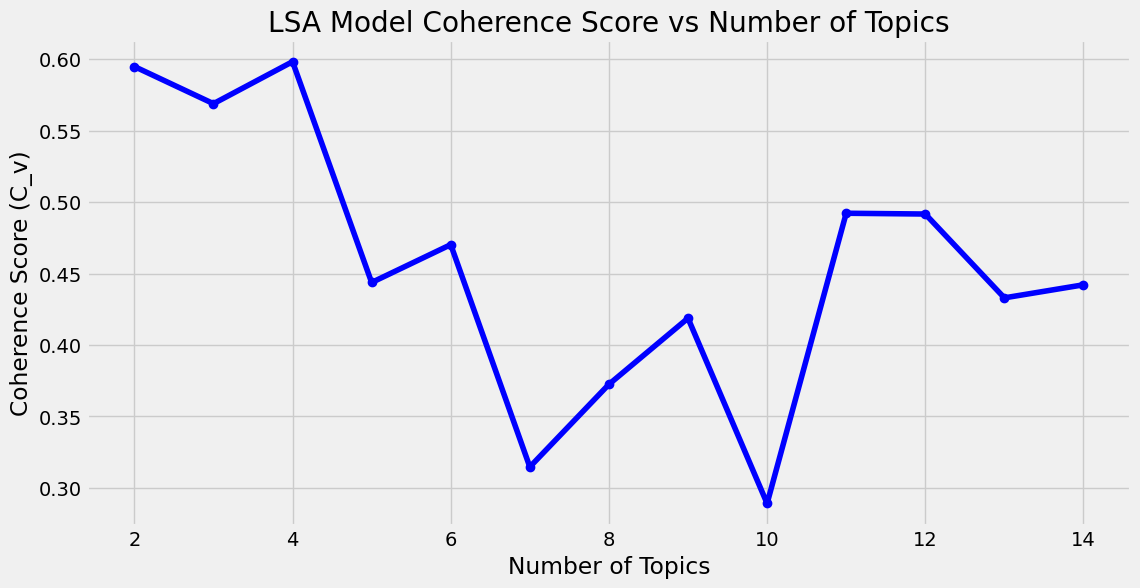

Optimal number of topics: 4
Best coherence score: 0.5982
Original dictionary size: 2884
Filtered dictionary size: 883


In [14]:
document_list, titles = load_data_from_dataframe(df['summary'])
clean_text = enhanced_preprocess_data(document_list, df)  # NEW
optimal_topics, _, _ = find_optimal_topics_gensim(clean_text)  # NEW
lsamodel, dictionary, tfidf_matrix = create_enhanced_lsa_model(clean_text, optimal_topics)  # NEW

In [17]:
words = 10
for i, topic in lsamodel.print_topics(num_topics=4, num_words=words):
    print(f"Topic {i}: {topic}\n")

Topic 0: -0.205*"indic" + -0.202*"concess" + -0.201*"deforest" + -0.196*"forest" + -0.166*"plantat" + -0.133*"clear" + -0.114*"clearanc" + -0.110*"illeg" + -0.108*"investig" + -0.108*"alleg"

Topic 1: -0.367*"indic" + -0.282*"deforest" + -0.268*"concess" + -0.176*"feb" + -0.175*"sep" + 0.166*"illeg" + -0.165*"insid" + 0.150*"investig" + 0.138*"grievanc" + 0.129*"estat"

Topic 2: -0.175*"right" + 0.167*"indic" + -0.150*"violat" + 0.138*"illeg" + -0.138*"worker" + 0.137*"investig" + -0.132*"labour" + 0.128*"grievanc" + 0.119*"estat" + 0.109*"deforest"

Topic 3: -0.259*"suppli" + -0.258*"link" + -0.249*"chain" + -0.173*"supplier" + 0.173*"indic" + -0.172*"rayatama" + -0.170*"mulia" + -0.164*"kahuripan" + -0.164*"dharma" + -0.164*"krida"



In [18]:
import pandas as pd
import numpy as np
import re

def enhanced_format_topics_sentences(model=None, corpus=None, texts=None, number_of_topics=None):
    """
    Enhanced version of format_topics_sentences that works with the improved LSA model

    Input:
        - model: Enhanced LSA model from create_enhanced_lsa_model
        - corpus: TF-IDF matrix from enhanced_prepare_corpus
        - texts: Original text documents (summary column)
        - number_of_topics: Number of topics in the model
    Output:
        - DataFrame with enhanced topic analysis
    """
    if number_of_topics is None:
        number_of_topics = model.num_topics

    # Collect rows in a list
    rows = []

    for i, doc in enumerate(model[corpus]):
        # Handle edge case where document has no topics
        if not doc:
            # Create empty row for documents with no topic assignments
            empty_row = {
                'Dominant_Topic': -1,
                'Perc_Contribution': 0.0,
                'Topic_Keywords': 'No topics assigned',
                'Text': texts[i],
                'Is_Outlier': True,
                'Dom_Topics_Num': 0,
                'Topic_Strength': 'Very Low'
            }
            # Add empty topic distributions
            for topic_id in range(number_of_topics):
                empty_row[f"Topic_{topic_id}_Perc"] = 0.0
                empty_row[f"Topic_{topic_id}_Indicate"] = 0
            rows.append(empty_row)
            continue

        # Create Dict for Topic contributions, and normalize values
        total_weight = sum(abs(weight) for _, weight in doc)

        # Avoid division by zero
        if total_weight == 0:
            total_weight = 1e-10

        topic_dist = {
            f"Topic_{topic_id}_Perc": round((abs(weight) / total_weight) * 100, 2)
            for topic_id, weight in doc
        }

        # Initialize all topics to 0 (in case some topics are missing from this document)
        for topic_id in range(number_of_topics):
            if f"Topic_{topic_id}_Perc" not in topic_dist:
                topic_dist[f"Topic_{topic_id}_Perc"] = 0.0

        # Create Dict for Multi-Label Binary Classification
        topic_binary = {
            f"Topic_{topic_id}_Indicate": 0
            for topic_id in range(number_of_topics)
        }

        shared_perc = 0  # Shared contribution amongst topics given to document
        sorted_doc = sorted(topic_dist.items(), key=lambda x: abs(x[1]), reverse=True)
        dom_topic_num = 0
        dom_topic_perc = 0.0
        is_outlier = False

        # Get Dominant Topics
        itr = 0
        while (shared_perc < 50.0) and (itr < len(sorted_doc)):
            # Get Topic Number and Topic Percentage
            topic_num, topic_perc = sorted_doc[itr]
            topic_num = int(re.search(r'\d+', topic_num).group())  # Use REGEX to grab num
            shared_perc += topic_perc
            topic_binary[f"Topic_{topic_num}_Indicate"] = 1  # Multi-Label Binary Classification

            # Get Prime Dominant Topic
            if itr == 0:
                dom_topic_num = topic_num
                dom_topic_perc = topic_perc
            itr += 1

            # Check if Outlier (document spread across too many topics)
            if itr > (number_of_topics / 2):
                is_outlier = True
                break

        # Enhanced: Categorize topic strength
        if dom_topic_perc >= 60:
            topic_strength = "Very High"
        elif dom_topic_perc >= 40:
            topic_strength = "High"
        elif dom_topic_perc >= 25:
            topic_strength = "Medium"
        elif dom_topic_perc >= 15:
            topic_strength = "Low"
        else:
            topic_strength = "Very Low"
            is_outlier = True

        # Get topic keywords with better error handling
        try:
            topic_keywords = ", ".join([word for word, _ in model.show_topic(dom_topic_num)])
        except:
            topic_keywords = "Keywords unavailable"

        # Enhanced: Calculate topic diversity (entropy-like measure)
        topic_probs = [topic_dist[f"Topic_{i}_Perc"]/100 for i in range(number_of_topics)]
        topic_probs = [p for p in topic_probs if p > 0]  # Remove zero probabilities
        if len(topic_probs) > 1:
            topic_diversity = -sum(p * np.log2(p) for p in topic_probs)
        else:
            topic_diversity = 0.0

        # Create Row for Document
        row = {
            'Dominant_Topic': int(dom_topic_num),
            'Perc_Contribution': dom_topic_perc,
            'Topic_Keywords': topic_keywords,
            'Text': texts[i],
            'Is_Outlier': is_outlier,
            'Dom_Topics_Num': itr,
            'Topic_Strength': topic_strength,
            'Topic_Diversity': round(topic_diversity, 3),
            'Shared_Perc_50': shared_perc  # How much % needed to reach 50%
        }
        row.update(topic_dist)  # Add individual topic contributions
        row.update(topic_binary)  # Add Multi-Label Binary Classification for topics
        rows.append(row)

    # Create DataFrame
    sent_topics_df = pd.DataFrame(rows)

    # Enhanced: Add some summary statistics
    print(f"=== TOPIC ASSIGNMENT SUMMARY ===")
    print(f"Total documents processed: {len(sent_topics_df)}")
    print(f"Outlier documents: {sent_topics_df['Is_Outlier'].sum()}")
    print(f"Average dominant topic strength: {sent_topics_df['Perc_Contribution'].mean():.2f}%")
    print(f"\nTopic Strength Distribution:")
    print(sent_topics_df['Topic_Strength'].value_counts())
    print(f"\nDominant Topic Distribution:")
    print(sent_topics_df['Dominant_Topic'].value_counts().sort_index())

    return sent_topics_df

def analyze_topic_quality(topic_df):
    """
    Additional function to analyze the quality of topic assignments
    """
    print("\n=== TOPIC QUALITY ANALYSIS ===")

    # Documents with very low dominant topic strength (potential issues)
    weak_assignments = topic_df[topic_df['Perc_Contribution'] < 20]
    print(f"Documents with weak topic assignment (<20%): {len(weak_assignments)}")

    # Documents with high diversity (spread across many topics)
    high_diversity = topic_df[topic_df['Topic_Diversity'] > 2.0]
    print(f"Documents with high topic diversity: {len(high_diversity)}")

    # Topic balance
    topic_counts = topic_df['Dominant_Topic'].value_counts().sort_index()
    print(f"\nTopic balance (documents per topic):")
    for topic_id, count in topic_counts.items():
        percentage = (count / len(topic_df)) * 100
        print(f"Topic {topic_id}: {count} documents ({percentage:.1f}%)")

    return {
        'weak_assignments': weak_assignments,
        'high_diversity': high_diversity,
        'topic_balance': topic_counts
    }

# Usage example with your enhanced LSA model:
def create_enhanced_dataframe(df, summary_column='summary'):
    """
    Complete workflow to create enhanced topic dataframe
    """
    # Step 1: Get your enhanced model (using the previous code)
    document_list, titles = load_data_from_dataframe(df[summary_column])
    clean_text = enhanced_preprocess_data(document_list, df)

    # Find optimal topics and create model
    optimal_topics, _, _ = find_optimal_topics_gensim(clean_text)
    lsamodel, dictionary, tfidf_matrix = create_enhanced_lsa_model(clean_text, optimal_topics)

    # Step 2: Create enhanced dataframe
    enhanced_df = enhanced_format_topics_sentences(
        model=lsamodel,
        corpus=tfidf_matrix,
        texts=document_list,
        number_of_topics=optimal_topics
    )

    # Step 3: Analyze quality
    quality_analysis = analyze_topic_quality(enhanced_df)

    return enhanced_df, quality_analysis

# If you want to use it with your existing model:
def use_with_existing_model(existing_model, existing_corpus, document_list, number_of_topics):
    """
    Use the enhanced function with your existing model and corpus
    """
    enhanced_df = enhanced_format_topics_sentences(
        model=existing_model,
        corpus=existing_corpus,
        texts=document_list,
        number_of_topics=number_of_topics
    )

    return enhanced_df

In [26]:
dominant_topic_df = enhanced_format_topics_sentences(
    model=lsamodel,
    corpus=tfidf_matrix,
    texts=document_list,
    number_of_topics=optimal_topics
).reset_index()

dominant_topic_df.to_csv("Enhanced_LSA_results.csv", index=False)

=== TOPIC ASSIGNMENT SUMMARY ===
Total documents processed: 381
Outlier documents: 0
Average dominant topic strength: 47.12%

Topic Strength Distribution:
Topic_Strength
High         226
Medium       102
Very High     53
Name: count, dtype: int64

Dominant Topic Distribution:
Dominant_Topic
0    219
1     40
2     90
3     32
Name: count, dtype: int64


In [25]:
dominant_topic_df

,index,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text,Is_Outlier,Dom_Topics_Num,Topic_Strength,Topic_Diversity,Shared_Perc_50,Topic_0_Perc,Topic_1_Perc,Topic_2_Perc,Topic_3_Perc,Topic_0_Indicate,Topic_1_Indicate,Topic_2_Indicate,Topic_3_Indicate
0,0,2,46.15,"right, indic, violat, illeg, worker, investig,...",That the Respondent allegedly transferred the ...,False,2,High,1.809,72.00,25.85,16.06,46.15,11.94,1,0,1,0
1,1,2,39.16,"right, indic, violat, illeg, worker, investig,...",The Complainant alleges that the Respondent ha...,False,2,Medium,1.812,71.84,32.68,20.29,39.16,7.87,1,0,1,0
2,2,2,42.25,"right, indic, violat, illeg, worker, investig,...",1.The Complainant alleges that the Respondent ...,False,2,High,1.579,83.29,41.04,14.47,42.25,2.24,1,0,1,0
3,3,0,39.10,"indic, concess, deforest, forest, plantat, cle...",The Respondent's Corporate Social Responsibili...,False,2,Medium,1.768,73.33,39.10,20.95,34.23,5.73,1,0,1,0
4,4,0,49.64,"indic, concess, deforest, forest, plantat, cle...",The Complainant alleges that the Respondent br...,False,2,High,1.595,83.11,49.64,3.88,33.47,13.01,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,376,0,46.12,"indic, concess, deforest, forest, plantat, cle...",Alleged labour rights violation in Malaysian g...,False,2,High,1.611,84.12,46.12,10.77,38.00,5.11,1,0,1,0
377,377,3,37.37,"suppli, link, chain, supplier, indic, rayatama...",Alleged clearance of potential High Carbon Sto...,False,2,Medium,1.722,72.74,35.37,23.78,3.48,37.37,1,0,0,1
378,378,0,62.12,"indic, concess, deforest, forest, plantat, cle...",Alleged forest clearance and involvement in la...,False,1,Very High,1.409,62.12,62.12,25.91,4.10,7.87,1,0,0,0
379,379,0,63.93,"indic, concess, deforest, forest, plantat, cle...",Alleged threats to the biodiversity of Leuser ...,False,1,Very High,1.403,63.93,63.93,22.12,3.46,10.49,1,0,0,0


## create_gensim_lsa_model

In [58]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary, tfidf_matrix,tfidf_model=prepare_corpus(doc_clean)

    lsamodel = LsiModel(tfidf_matrix, num_topics=number_of_topics, id2word = dictionary, random_seed=1)
    #print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

## Compute Coherence Values

In [59]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute u_mass coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary, random_seed=1)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Coherence Predictions



In [60]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,tfidf_matrix,tfidf_model=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, tfidf_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

# Load and preprocess the data to create clean_text
document_list, titles = load_data_from_dataframe(df['summary'])
clean_text = preprocess_data(document_list)


start,stop,step=2,12,1

Total Number of Documents: 387


Original dictionary size: 2884
Filtered dictionary size: 883


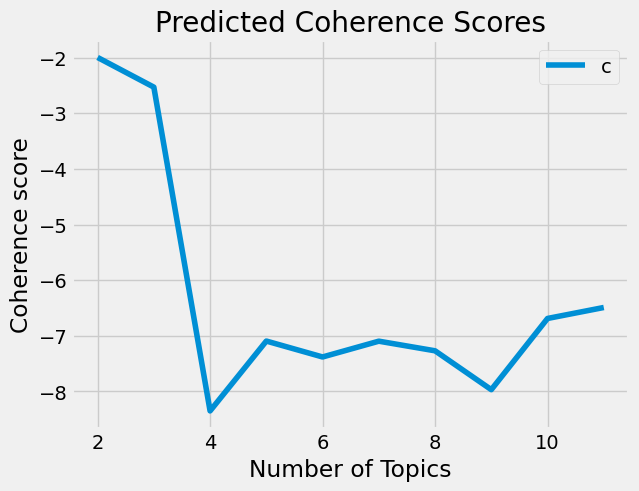

In [61]:
plt.title("Predicted Coherence Scores")

plot_graph(clean_text,start,stop,step)

# Model Creation

In [62]:
summary = df['summary'].dropna().tolist()

# LSA Model
number_of_topics = 5
words = 10
document_list, titles = load_data_from_dataframe(df['summary'])
clean_text=preprocess_data(document_list)
lsamodel=create_gensim_lsa_model(clean_text,number_of_topics,words)

Total Number of Documents: 387
Original dictionary size: 2884
Filtered dictionary size: 883


## Raw Results

In [63]:
for i, topic in lsamodel.print_topics(num_topics=number_of_topics, num_words=words):
    print(f"Topic {i}: {topic}\n")

Topic 0: -0.201*"deforest" + -0.199*"indic" + -0.197*"concess" + -0.193*"forest" + -0.166*"plantat" + -0.132*"supplier" + -0.130*"clear" + -0.114*"right" + -0.110*"clearanc" + -0.110*"illeg"

Topic 1: -0.382*"indic" + -0.285*"deforest" + -0.279*"concess" + -0.184*"feb" + -0.184*"sep" + -0.172*"insid" + 0.157*"illeg" + 0.141*"investig" + -0.132*"aug" + -0.131*"nov"

Topic 2: 0.202*"right" + 0.157*"violat" + 0.149*"labour" + -0.142*"illeg" + 0.140*"worker" + -0.139*"investig" + -0.130*"indic" + -0.129*"grievanc" + -0.126*"supplier" + -0.120*"estat"

Topic 3: 0.266*"suppli" + 0.261*"link" + 0.254*"chain" + 0.201*"supplier" + -0.178*"indic" + 0.165*"compliant" + 0.162*"mulia" + 0.162*"rayatama" + -0.159*"concess" + 0.154*"krida"

Topic 4: 0.265*"right" + -0.244*"leuser" + -0.243*"biodivers" + -0.241*"clearanc" + 0.241*"labour" + -0.223*"forest" + -0.211*"ecosystem" + 0.181*"worker" + -0.181*"impact" + 0.179*"violat"



# Coherence Score

In [64]:
dictionary, _ , _ = prepare_corpus(clean_text)

coherence_model = CoherenceModel(model=lsamodel, texts=clean_text, dictionary=dictionary, coherence='u_mass')
coherence_score = coherence_model.get_coherence()
coherence_score

Original dictionary size: 2884
Filtered dictionary size: 883


-7.09337138490025

# Visualizations



In [65]:
model_name = "LSA"

## Create Dataframe with Results

In [66]:
#Input: LSA model, corpus (in this case TFIDF matrix), text (summary column)
#Output: Dataframe consisting of every row
def format_topics_sentences(model=None, corpus=None, texts=None):
    # Collect rows in a list
    rows = []

    for i, doc in enumerate(model[corpus]):
        # Create Dict for Topic contributions, and normalize values
        total_weight = sum(abs(weight) for _, weight in doc)
        topic_dist = {
            f"Topic_{topic_id}_Perc": round((abs(weight) / total_weight) * 100, 2) # Finds and normalizes weights for each topic
            for topic_id, weight in doc
        }

        # Create Dict for Multi-Label Binary Classifcation
        topic_binary = {
            f"Topic_{topic_id}_Indicate": 0
            for topic_id, weight in doc
        }

        shared_perc = 0 # Shared contribution amongst topics given to document
        sorted_doc = sorted(topic_dist.items(), key=lambda x: abs(x[1]), reverse=True)
        dom_topic_num = 0
        dom_topic_perc = 0.0
        is_outlier = False

        # Get Dominant Topics
        itr = 0
        while (shared_perc < 50.0):
            # Get Topic Number and Topic Percentage
            topic_num, topic_perc = sorted_doc[itr]
            topic_num = int(re.search(r'\d+', topic_num).group()) # Use REGEX to grab num
            shared_perc += topic_perc
            topic_binary[f"Topic_{topic_num}_Indicate"] = 1  # Multi-Label Binary Classifcation

            # Get Prime Dominant Topic
            if itr == 0:
                dom_topic_num = topic_num
                dom_topic_perc = topic_perc
            itr += 1

            # Check if Outlier
            if (itr) > (number_of_topics/2):
                is_outlier = True



        topic_keywords = ", ".join([word for word, _ in model.show_topic(dom_topic_num)])

        # Create Row for Document
        row = {
            'Dominant_Topic': int(dom_topic_num),
            'Perc_Contribution': dom_topic_perc,
            'Topic_Keywords': topic_keywords,
            'Text': texts[i],
            'Is_Outlier': is_outlier,
            'Dom_Topics_Num': itr
        }
        row.update(topic_dist) # Add individual topic contributions
        row.update(topic_binary) # Add Multi-Label Binary Classifcation for topics
        rows.append(row)

    # Create DataFrame
    sent_topics_df = pd.DataFrame(rows)
    return sent_topics_df

In [67]:
# Grab TFIDF matrix from prev functions
_ , tfidf_matrix , _ = prepare_corpus(clean_text)

# Format
dominant_topic_df = format_topics_sentences(model=lsamodel, corpus=tfidf_matrix, texts=document_list).reset_index()
#dominant_topic_df.head(10)

Original dictionary size: 2884
Filtered dictionary size: 883


In [68]:
# Convert to CSV and save
dominant_topic_df.to_csv("LSA_results.csv",index = False)
from google.colab import files
# files.download("LSA_results.csv")

## Data Exploration

In [69]:
dominant_topic_df[dominant_topic_df['Dominant_Topic'] == 2]

,index,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text,Is_Outlier,Dom_Topics_Num,Topic_0_Perc,Topic_1_Perc,Topic_2_Perc,Topic_3_Perc,Topic_4_Perc,Topic_0_Indicate,Topic_1_Indicate,Topic_2_Indicate,Topic_3_Indicate,Topic_4_Indicate
0,0,2,37.63,"right, violat, labour, illeg, worker, investig...",That the Respondent allegedly transferred the ...,False,2,20.74,14.50,37.63,6.85,20.28,1,0,1,0,0
1,1,2,32.71,"right, violat, labour, illeg, worker, investig...",The Complainant alleges that the Respondent ha...,False,2,27.14,18.34,32.71,4.72,17.09,1,0,1,0,0
2,2,2,39.12,"right, violat, labour, illeg, worker, investig...",1.The Complainant alleges that the Respondent ...,False,2,38.61,15.27,39.12,4.20,2.80,1,0,1,0,0
5,5,2,36.15,"right, violat, labour, illeg, worker, investig...",1. The Complainant alleges that he informed th...,False,2,25.36,13.78,36.15,10.18,14.53,1,0,1,0,0
7,7,2,37.74,"right, violat, labour, illeg, worker, investig...",The Complainant alleges that the Respondent ha...,False,2,23.86,16.62,37.74,9.43,12.35,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,310,2,33.39,"right, violat, labour, illeg, worker, investig...","In May/June 2021, Eyes On the Forest (EOF) pub...",False,2,25.35,30.49,33.39,4.33,6.45,0,1,1,0,0
311,311,2,33.39,"right, violat, labour, illeg, worker, investig...","In May/June 2021, Eyes On the Forest (EOF) pub...",False,2,25.35,30.49,33.39,4.33,6.45,0,1,1,0,0
312,312,2,33.39,"right, violat, labour, illeg, worker, investig...","In May/June 2021, Eyes On the Forest (EOF) pub...",False,2,25.35,30.49,33.39,4.33,6.45,0,1,1,0,0
313,313,2,33.39,"right, violat, labour, illeg, worker, investig...","In May/June 2021, Eyes On the Forest (EOF) pub...",False,2,25.35,30.49,33.39,4.33,6.45,0,1,1,0,0


## Avg Dominant Topic Contribution

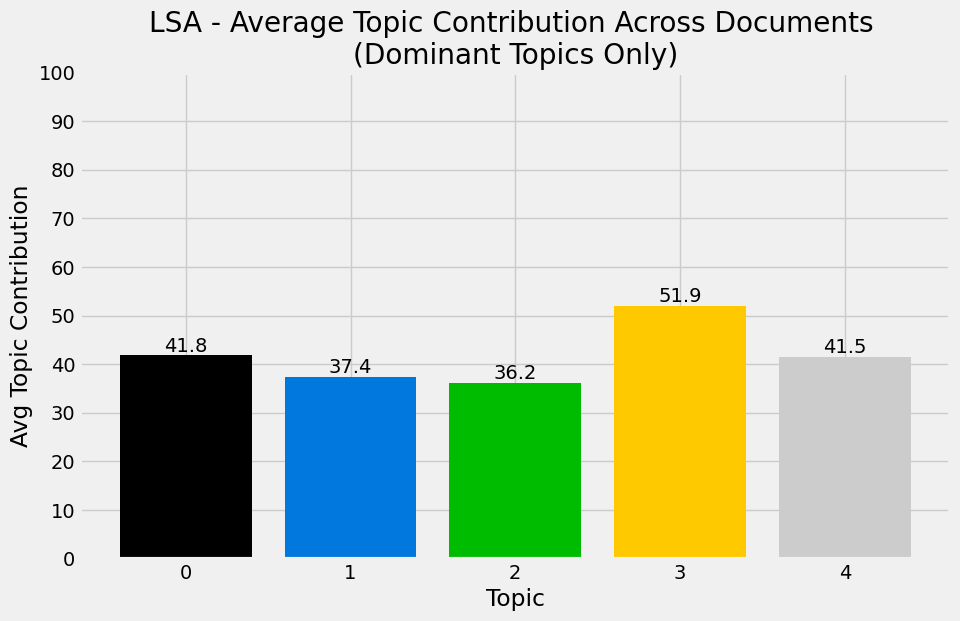

In [70]:
# Prepare data
topic_avg_df = dominant_topic_df.groupby('Dominant_Topic')['Perc_Contribution'].mean().reset_index()
indexes = topic_avg_df['Dominant_Topic']
values = topic_avg_df['Perc_Contribution'].round(1)

colors = plt.cm.nipy_spectral(np.linspace(0, 1, len(indexes)))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(indexes, values, color=colors[:len(indexes)])
ax.bar_label(bars)

# Labels and title
ax.set_title(f'{model_name} - Average Topic Contribution Across Documents \n(Dominant Topics Only)')
ax.set_xlabel('Topic')
ax.set_ylabel('Avg Topic Contribution')
plt.xticks(indexes)
plt.yticks(range(0,101,10))
plt.show()

## Dominant Topic Frequency

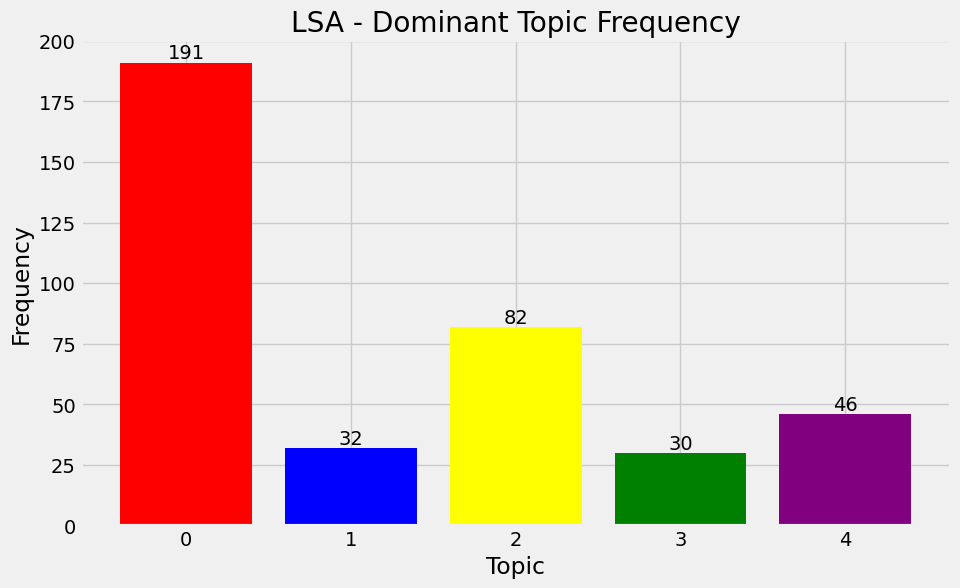

In [71]:
# Prepare data
topics_df = dominant_topic_df.groupby(['Dominant_Topic'])['index'].count().reset_index()
indexes = topics_df['Dominant_Topic']
values = topics_df['index']
colors_7 = ['red', 'blue', 'yellow', 'green', 'purple', 'orange', 'cyan']

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(indexes, values, color=colors_7[:len(indexes)])
ax.bar_label(bars)

# Labels and title
ax.set_title(f'{model_name} - Dominant Topic Frequency')
ax.set_xlabel('Topic')
ax.set_ylabel('Frequency')
plt.show()

## Topic Distribution per Doc

In [ ]:
def topic_dist_doc(df, n_topics, doc_num):
    import matplotlib.pyplot as plt

    topics = []
    values = []

    doc_row = df[df['index'] == doc_num]

    for i in range(n_topics):
        col_name = f"Topic_{i}_Perc"
        val = doc_row[col_name].values[0] if not doc_row.empty and pd.notnull(doc_row[col_name].values[0]) else 0.0
        topics.append(col_name)
        values.append(float(val))  # Ensure it's a float

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(topics, values, color='red')
    plt.xlabel('Topics')
    plt.ylabel('Topic Contribution')
    plt.title(f'{model_name} - Topic Distribution for Document {doc_num}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

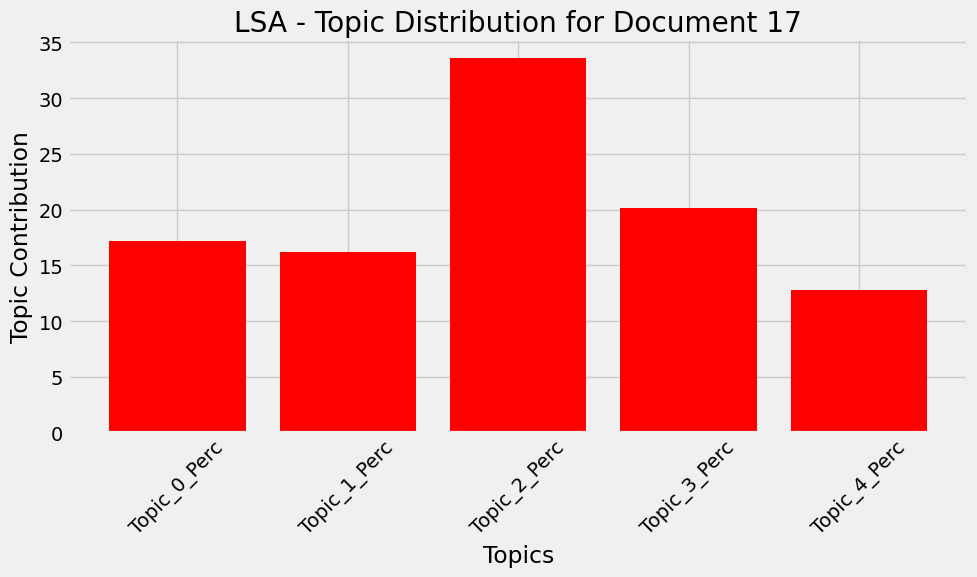

In [ ]:
topic_dist_doc(dominant_topic_df, number_of_topics, 17)

## Wordclouds

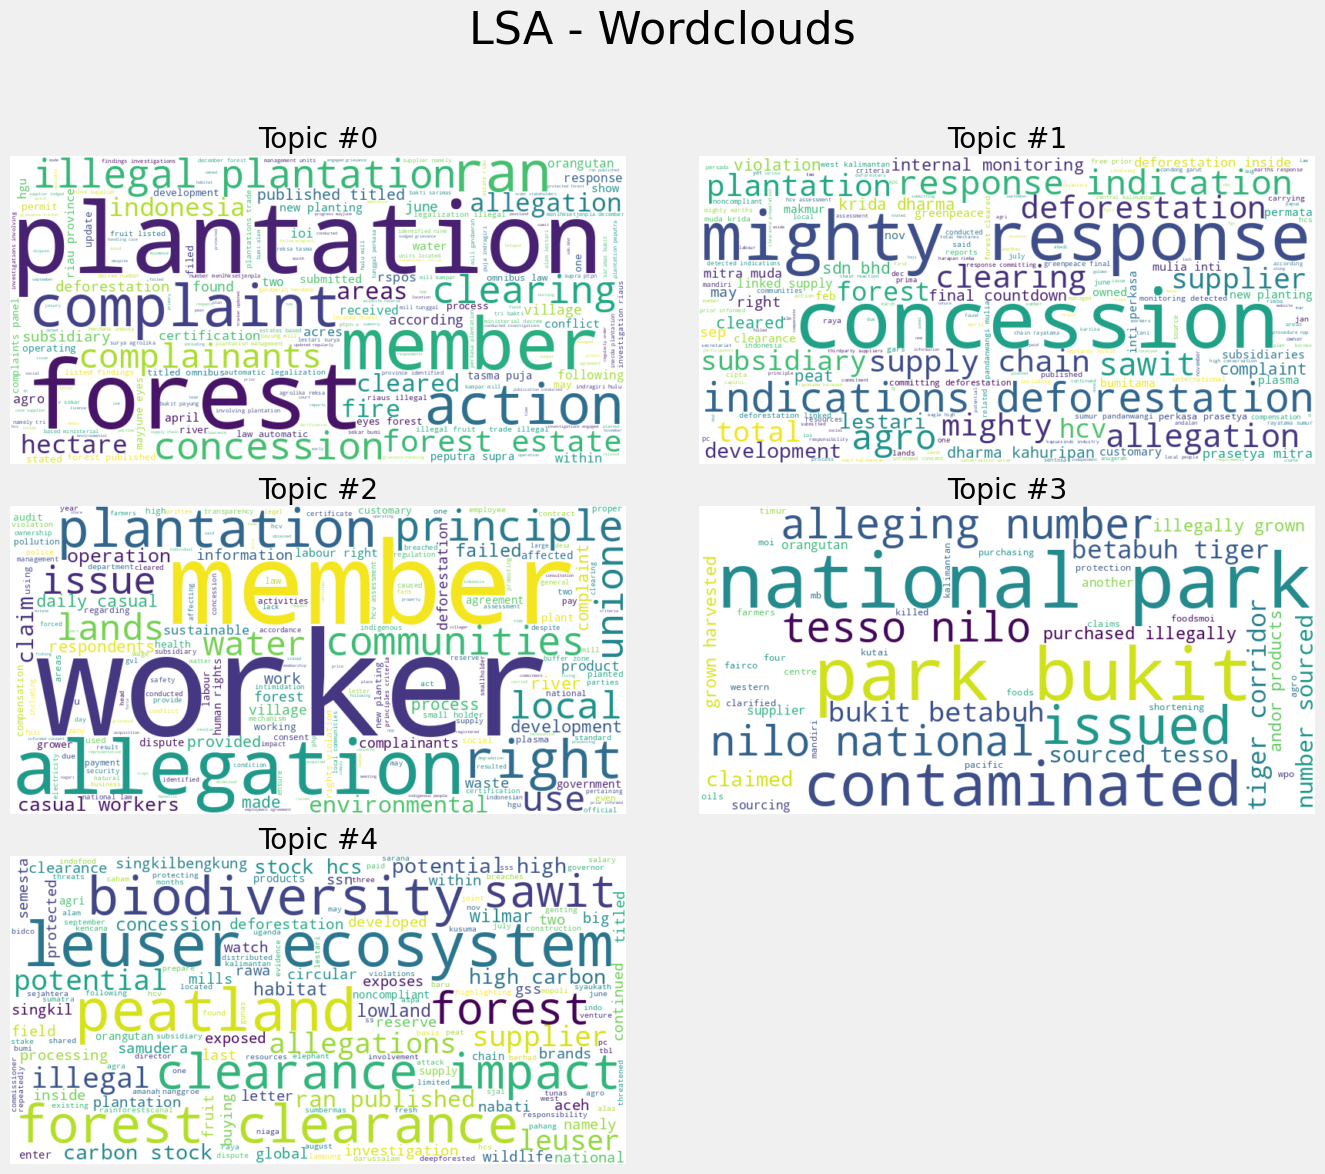

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

# Input: Receives dataframe containing all rows with classification, table title, and number of topics
# Output: Displays n word clouds
def display_wordcloud(df, title, n_topics):

  n_cols = 2
  n_rows = int(np.ceil(n_topics / n_cols))
  fig = plt.figure(figsize=(14, 4 * n_rows))

  for topic in range(n_topics):
    topic_df = dominant_topic_df[dominant_topic_df['Dominant_Topic'] == topic]
    text = ' '.join(topic_df['Text'].astype(str).tolist()) # Joining the words of each text of each row into a list separated by ' '
    text = re.sub(r'[^A-Za-z\s]', '', text) # Substituting/deleting anything that IS NOT a letter Aa-Zz with ''
    text = text.lower()
    en_stop = set(stopwords.words('english') + stopwords_extra)
    text = ' '.join(word for word in text.split() if word not in en_stop)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    ax = fig.add_subplot(n_rows, n_cols, topic + 1)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"Topic #{topic}")
    ax.axis("off")

  fig.suptitle(title, fontsize=32)
  plt.tight_layout(rect=[0, 0, 1, 0.95])
  plt.show()


display_wordcloud(df=dominant_topic_df, title=f'{model_name} - Wordclouds', n_topics=number_of_topics)

## Overall Dominant Topic % share

Text(0, 0.5, 'Number of Documents')

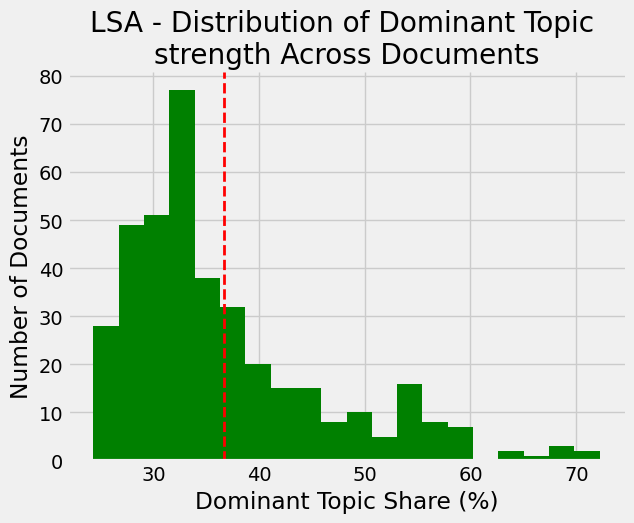

In [ ]:
# Displays every doc's dominant topic share as a percentage compared to its other non-dominant topics
# Basically how much weight the dominant topic have throughout each of the documents
dominant_topic_df['Perc_Contribution'].plot(kind='hist', bins=20, title='Perc_Contribution', color='green')
plt.gca().spines[['top', 'right',]].set_visible(False)

plt.title(f"{model_name} - Distribution of Dominant Topic \nstrength Across Documents")

mean_value = dominant_topic_df['Perc_Contribution'].mean()
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')

plt.xlabel("Dominant Topic Share (%)")
plt.ylabel("Number of Documents")